In [ ]:
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import geoviews as gv
import hvplot.xarray
import holoviews as hv
gv.extension('bokeh', 'matplotlib')

warnings.filterwarnings("ignore")

## PO DAAC Catalog exploration using the CMR API

- The search is restricted to colections that have data over a given time window

In [2]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 300,
                            'temporal': ['2021-10-01T10:00:00Z','2021-11-01T00:00:00Z'] 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )

In [3]:
response.headers['cmr-hits']

'117'

### Loop through each response in the catalog and print the respective concep ID

In [4]:
for r in response.json()['items']:
    print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

JASON_CS_S6A_L2_ALT_LR_STD_OST_NRT_F ==>  C1968979597-POCLOUD
MUR-JPL-L4-GLOB-v4.1 ==>  C1996881146-POCLOUD
JASON_CS_S6A_L2_ALT_LR_STD_OST_STC_F ==>  C1968980609-POCLOUD
ASCATA-L2-25km ==>  C2075141524-POCLOUD
JASON_CS_S6A_L2_ALT_LR_STD_OST_NTC_F_UNVALIDATED ==>  C1968979551-POCLOUD
MODIS_T-JPL-L2P-v2019.0 ==>  C1940475563-POCLOUD
MUR25-JPL-L4-GLOB-v4.2 ==>  C2036880657-POCLOUD
VIIRS_N20-OSPO-L2P-v2.61 ==>  C1996880450-POCLOUD
ABI_G16-STAR-L2P-v2.70 ==>  C2036877465-POCLOUD
ABI_G16-STAR-L3C-v2.70 ==>  C2036877612-POCLOUD
ABI_G17-STAR-L2P-v2.71 ==>  C2036877626-POCLOUD
ABI_G17-STAR-L3C-v2.71 ==>  C2036877645-POCLOUD
AHI_H08-STAR-L2P-v2.70 ==>  C2036877480-POCLOUD
AHI_H08-STAR-L3C-v2.70 ==>  C2036877660-POCLOUD
AMSR2-REMSS-L2P-v8a ==>  C2036880594-POCLOUD
AMSR2-REMSS-L2P-v8a ==>  C2068529568-POCLOUD
AMSR2-REMSS-L3U-v8a ==>  C2036877487-POCLOUD
AMSR2-REMSS-L3U_RT-v8a ==>  C2108869784-POCLOUD
ASCATA-L2-Coastal ==>  C1996881752-POCLOUD
ASCATB-L2-25km ==>  C2075141559-POCLOUD
ASCATB-L2-Coast

### Loading credentials for direct access

In [5]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [6]:
# Cal bounding box
lon_min = -126.
lon_max = -121.
lat_min = 36.
lat_max = 39.

In [7]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

response = requests.get(url, 
                        params={
                            'concept_id': 'C2036880650-POCLOUD',
                            'temporal': '2021-10-21T00:00:00Z,2021-11-05T23:59:59Z',
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 200,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
17


In [8]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][0]['href'])
granules_url

['s3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211020.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211021.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211022.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211023.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211024.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211025.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS_AQUA_L3_SST_THERMAL_DAILY_4KM_DAYTIME_V2019.0/AQUA_MODIS.20211026.L3m.DAY.SST.sst.4km.NRT.nc',
 's3://podaac-ops-cumulus-protected/MODIS

## Plot all SST images available during the S-MODE windows and pick good days

The MODIS files don't have a time dimention, so we have to "guess"the time from the filaname or the start_time, end_time attributes in the netcdf files. Now, I'm defining a preprocessing funcion to grab the time and add a time dimension on each dataset so I can use open_mfdataset to concatenate the data

In [9]:
def extract_time(ds):
    t0 = np.datetime64(pd.to_datetime(ds.time_coverage_start).date())
    return ds.expand_dims(time=[t0])

In [10]:
file_list =  [fs.open(file) for file in granules_url]
ds = xr.open_mfdataset(file_list, preprocess=extract_time, engine='h5netcdf')

In [11]:
lon_min = -126.
lon_max = -121.
lat_min = 32.
lat_max = 40.
sst = ds.sst.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
sst.hvplot(groupby='time', width=600, height=400, clim=(10, 20), cmap='plasma')

:DynamicMap   [time]
   :Image   [lon,lat]   (sst)

#### Doing some wrangling on the Saildrone data

In [12]:
def preprocess_saildrone(sd_id, start_time, end_time):
    ds_sd = xr.open_dataset('http://smode.whoi.edu:8080/thredds/dodsC/insitu/saildrone/{}_1min.nc'.format(sd_id))
    sd_time = ds_sd.time
    ds_sd['obs'] = sd_time
    del ds_sd['time']
    ds_sd = ds_sd.rename({'obs': 'time'})
    sd_sub = ds_sd.sel(time=slice(start_time, end_time))
    return sd_sub

In [13]:
# grab polygon from S-MODE repo
map_url = 'https://raw.githubusercontent.com/NASA-SMODE/Maps/main/tools/' 
ops_area = pd.read_json(map_url + 'ops_area_polygon.json')

### Now, we pick a day (MODIS data is daily) and plot the SD data on top of the MODIS SST

In [14]:
start_time = '2021-10-25T00:00:00.000000000'
end_time = '2021-10-25T23:59:59.000000000'

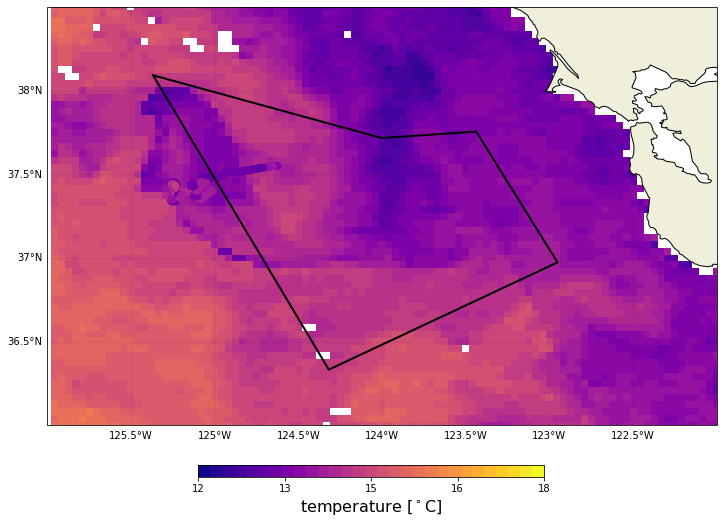

In [15]:
%matplotlib inline

lon_min = -126.
lon_max = -122.
lat_min = 36.
lat_max = 38.5

cmap = 'plasma'
vmin = 12
vmax = 18
norm = matplotlib.colors.BoundaryNorm(boundaries=np.linspace(vmin, vmax, 30), ncolors=256)
proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent(extent)
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=2)
ax.plot(ops_area.longitude, ops_area.latitude, color='k', lw=2, transform=proj)
cs = ax.pcolormesh(sst.lon, sst.lat, sst.sel(time=start_time, method='nearest'), norm=norm, transform=proj, cmap=cmap, alpha=1)

drone_ids = ['1072', '1073']
for sd_id in drone_ids:
    sd_ds = preprocess_saildrone(sd_id, start_time, end_time)
    ax.scatter(sd_ds.longitude, sd_ds.latitude, c=sd_ds.TEMP_DEPTH_HALFMETER_MEAN, s=40, norm=norm, transform=proj, cmap=cmap)
drone_ids = ['1062', '1075', '1074']
for sd_id in drone_ids:
    sd_ds = preprocess_saildrone(sd_id, start_time, end_time)
    ax.scatter(sd_ds.longitude, sd_ds.latitude, c=sd_ds.TEMP_SBE37_MEAN, s=40, norm=norm, transform=proj, cmap=cmap)
    
    
g = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='dotted')
g.right_labels = False
g.top_labels = False
cax = plt.axes([0.3, 0.05, 0.4, 0.02])
cbar = plt.colorbar(cs, cax=cax, format='%d', orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('temperature [$^\circ$C]', fontsize=16)